**Import the relevant libraries**

In [1]:
import pandas as pd
import numpy as np
import io # If you are not using Google Colab, you can skip the sentence containing 'import io'
import statsmodels.api as sm

#We will actually be importing more libraries later. 
#That is unconventional for coding, but done for ease of explination.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Upload the dataset**

In [2]:
from google.colab import files
raw_claims_data = files.upload()

# If you are not using Google Colab, skip this code cell

Saving OBGYN_practice_dataset.csv to OBGYN_practice_dataset.csv


**Upload the alternative category look up table**

In [3]:
from google.colab import files
raw_claims_data2 = files.upload()

# If you are not using Google Colab, skip this code cell

Saving OBGYN_categories_v2.csv to OBGYN_categories_v2.csv


**Import the two datasets**

In [6]:
raw_data1 = pd.read_csv(io.BytesIO(raw_claims_data['OBGYN_practice_dataset.csv']))
OBGYN_category_v2 = pd.read_csv(io.BytesIO(raw_claims_data2['OBGYN_categories_v2.csv']))

# If you are not using Google Colab, use a different code:

# raw_data1 = pd.read_csv(r'C:\Users\location of the csv file on your computer\\OBGYN_with categories.csv')
# OBGYN_category_v2 = pd.read_csv(r'C:\Users\location of the csv file on your computer\\OBGYN_category_v2.csv')


**Merge the two dataframes in order to get the alternative categorization**

In [8]:
merged = pd.merge(raw_data1, OBGYN_category_v2, on="procedure_concept_id")


**Inspect the dataset**

In [9]:
merged

,person_id,procedure_date,procedure_concept_id,concept_name_x,amount,total_paid,provider_id,provider_name,category according to process mining,concept_name_y
0,11248,8/3/2020,2004407,Amputation of cervix,1,839,45192,Baptist Health & Medical Center,Gynaecology,Amputation of cervix
1,11874,4/6/2020,2004407,Amputation of cervix,1,839,52356,Boudica Female Care,Gynaecology,Amputation of cervix
2,12745,12/20/2019,2004407,Amputation of cervix,1,839,24023,dr. Mariano & Co.,Gynaecology,Amputation of cervix
3,13133,7/29/2019,2004407,Amputation of cervix,1,839,24023,dr. Mariano & Co.,Gynaecology,Amputation of cervix
4,13844,8/31/2020,2004407,Amputation of cervix,1,839,45192,Baptist Health & Medical Center,Gynaecology,Amputation of cervix
...,...,...,...,...,...,...,...,...,...,...
52188,19298,9/26/2019,45890386,Abortion Procedures,1,1129,45192,Baptist Health & Medical Center,Gynaecology,Abortion Procedures
52189,19406,1/18/2020,45890386,Abortion Procedures,1,1129,45192,Baptist Health & Medical Center,Gynaecology,Abortion Procedures
52190,19435,8/26/2020,45890386,Abortion Procedures,1,1129,4823,East Westfield Health Services,Gynaecology,Abortion Procedures
52191,19656,4/30/2020,45890386,Abortion Procedures,1,1129,45192,Baptist Health & Medical Center,Gynaecology,Abortion Procedures


**Create a pivot table**

In [10]:
pivot = pd.pivot_table(merged, values = 'amount', index=['person_id'], columns = 'category according to process mining',aggfunc=np.sum).reset_index()

**Inspect the pivot table**

In [11]:
pivot

category according to process mining,person_id,Consultation,Delivery,Gynaecology,Obstetrics
0,10429,4.0,NaN,3.0,NaN
1,10430,10.0,1.0,NaN,8.0
2,10431,9.0,1.0,NaN,7.0
3,10432,6.0,NaN,NaN,6.0
4,10433,1.0,NaN,NaN,NaN
...,...,...,...,...,...
9258,19688,NaN,1.0,NaN,10.0
9259,19689,2.0,NaN,2.0,NaN
9260,19690,10.0,1.0,NaN,8.0
9261,19691,1.0,NaN,NaN,NaN


**Replace blank cells with zero**

In [12]:
raw_data = pivot.fillna(0)

**Inspect the new dataset**

In [13]:
raw_data

category according to process mining,person_id,Consultation,Delivery,Gynaecology,Obstetrics
0,10429,4.0,0.0,3.0,0.0
1,10430,10.0,1.0,0.0,8.0
2,10431,9.0,1.0,0.0,7.0
3,10432,6.0,0.0,0.0,6.0
4,10433,1.0,0.0,0.0,0.0
...,...,...,...,...,...
9258,19688,0.0,1.0,0.0,10.0
9259,19689,2.0,0.0,2.0,0.0
9260,19690,10.0,1.0,0.0,8.0
9261,19691,1.0,0.0,0.0,0.0


**Leave out the column containing the person_id**

In [14]:
dataset = raw_data.iloc[:,1:] 
#Note that now we are not making a distinction between input and target columns.
#We are simply removing the column containing the person_id because it has no quantifyable meaning.


**Inspect the new dataset**

In [15]:
dataset

category according to process mining,Consultation,Delivery,Gynaecology,Obstetrics
0,4.0,0.0,3.0,0.0
1,10.0,1.0,0.0,8.0
2,9.0,1.0,0.0,7.0
3,6.0,0.0,0.0,6.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
9258,0.0,1.0,0.0,10.0
9259,2.0,0.0,2.0,0.0
9260,10.0,1.0,0.0,8.0
9261,1.0,0.0,0.0,0.0


**Scale the dataset to make it suitable for this type of machine learning**

In [16]:
from sklearn import preprocessing 

# As mentioned in the introduction of this coding script,
# it is convential to import all libraries at the beginning of a script.
# Instead, we are putting it here, because that follows the sequence of explination of this lecture.

data_scaled = preprocessing.scale(dataset)
#Scaling our data will make it more suitable for machine learning.

**Apply Principal Component Analysis (PCA) on the scaled data**

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
principalComponents = pca.fit_transform(data_scaled)

#We are transforming our scaled input data to two principal components

**Create a dataframe of containing the two principal components**

In [48]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

#We create this Dataframe so we can add the PCA metrics to our original dataset.

,principal component 1,principal component 2
0,-0.553407,1.484696
1,4.253340,-0.090141
2,3.873277,-0.236250
3,1.381443,-0.323222
4,-0.728204,-1.038233
...,...,...
9258,2.964688,-1.737644
9259,-0.782404,0.482077
9260,4.253340,-0.090141
9261,-0.728204,-1.038233


**Evaluate the variance that is explained by PCA in our dataset** 

In [49]:
pca.explained_variance_ratio_

array([0.53844823, 0.28168063])

**Visualize the dataset along the two principal components in a scatterplot**

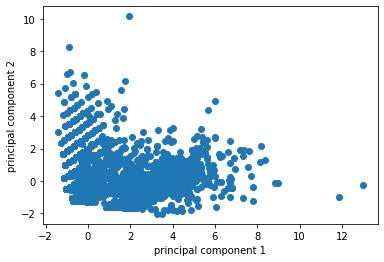

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline 
#If you are not using Google Colab, this line is not needed.
plt.scatter(principalComponents[:,0],principalComponents[:,1])
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

**Combine PCA with K-means clustering**

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(4)
kmeans.fit(principalComponents)
clusters_new = principalDf.copy()
clusters_new['cluster_pred'] = kmeans.fit_predict(principalComponents)




**Visualize PCA & K-Means**

Text(0, 0.5, 'principal component 2')

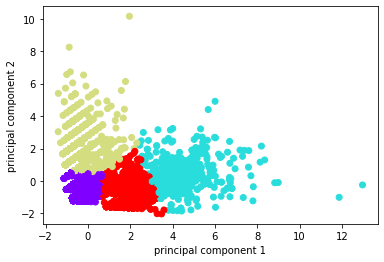

In [52]:
plt.scatter(clusters_new['principal component 1'],clusters_new['principal component 2'], c=clusters_new['cluster_pred']
,cmap='rainbow')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')


**Link the results from K-means clustering back to the tidy dataset**

In [53]:
identified_clusters = kmeans.fit_predict(data_scaled) 
data_with_clusters = raw_data.copy()
data_with_clusters['Cluster'] = identified_clusters
data_with_clusters


category according to process mining,person_id,Consultation,Delivery,Gynaecology,Obstetrics,Cluster
0,10429,4.0,0.0,3.0,0.0,2
1,10430,10.0,1.0,0.0,8.0,1
2,10431,9.0,1.0,0.0,7.0,1
3,10432,6.0,0.0,0.0,6.0,0
4,10433,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...
9258,19688,0.0,1.0,0.0,10.0,3
9259,19689,2.0,0.0,2.0,0.0,2
9260,19690,10.0,1.0,0.0,8.0,1
9261,19691,1.0,0.0,0.0,0.0,0


**Add the metric 'Distance from closest centroid' obtained from k-means clustering**

In [54]:
X_dist = kmeans.transform(data_scaled)**2
alldistances = kmeans.fit_transform(data_scaled)
totalDistance = np.min(alldistances, axis=1).round(2)
data_with_distance = data_with_clusters.copy()
data_with_distance['Distance_from_nearest_cluster'] = totalDistance
data_with_distance


category according to process mining,person_id,Consultation,Delivery,Gynaecology,Obstetrics,Cluster,Distance_from_nearest_cluster
0,10429,4.0,0.0,3.0,0.0,2,0.21
1,10430,10.0,1.0,0.0,8.0,1,0.68
2,10431,9.0,1.0,0.0,7.0,1,0.96
3,10432,6.0,0.0,0.0,6.0,0,2.36
4,10433,1.0,0.0,0.0,0.0,0,0.56
...,...,...,...,...,...,...,...
9258,19688,0.0,1.0,0.0,10.0,3,2.30
9259,19689,2.0,0.0,2.0,0.0,2,0.86
9260,19690,10.0,1.0,0.0,8.0,1,0.68
9261,19691,1.0,0.0,0.0,0.0,0,0.56


**Merge PCA metrics and k-means clustering metrics with the tidy dataset** 

In [55]:
PCA_kmeans = pd.concat([data_with_distance, principalDf], axis=1)
PCA_kmeans


,person_id,Consultation,Delivery,Gynaecology,Obstetrics,Cluster,Distance_from_nearest_cluster,principal component 1,principal component 2
0,10429,4.0,0.0,3.0,0.0,2,0.21,-0.553407,1.484696
1,10430,10.0,1.0,0.0,8.0,1,0.68,4.253340,-0.090141
2,10431,9.0,1.0,0.0,7.0,1,0.96,3.873277,-0.236250
3,10432,6.0,0.0,0.0,6.0,0,2.36,1.381443,-0.323222
4,10433,1.0,0.0,0.0,0.0,0,0.56,-0.728204,-1.038233
...,...,...,...,...,...,...,...,...,...
9258,19688,0.0,1.0,0.0,10.0,3,2.30,2.964688,-1.737644
9259,19689,2.0,0.0,2.0,0.0,2,0.86,-0.782404,0.482077
9260,19690,10.0,1.0,0.0,8.0,1,0.68,4.253340,-0.090141
9261,19691,1.0,0.0,0.0,0.0,0,0.56,-0.728204,-1.038233


In [56]:
PCA_kmeans.columns

Index(['person_id', 'Consultation', 'Delivery', 'Gynaecology', 'Obstetrics',
       'Cluster', 'Distance_from_nearest_cluster', 'principal component 1',
       'principal component 2'],
      dtype='object')

**Extract the relevant columns**

In [57]:
metrics_extracted = PCA_kmeans[['person_id','Cluster', 'Distance_from_nearest_cluster', 'principal component 1',
       'principal component 2' ]]
metrics_extracted

,person_id,Cluster,Distance_from_nearest_cluster,principal component 1,principal component 2
0,10429,2,0.21,-0.553407,1.484696
1,10430,1,0.68,4.253340,-0.090141
2,10431,1,0.96,3.873277,-0.236250
3,10432,0,2.36,1.381443,-0.323222
4,10433,0,0.56,-0.728204,-1.038233
...,...,...,...,...,...
9258,19688,3,2.30,2.964688,-1.737644
9259,19689,2,0.86,-0.782404,0.482077
9260,19690,1,0.68,4.253340,-0.090141
9261,19691,0,0.56,-0.728204,-1.038233


**Merge the extracted metrics with the original dataset**

In [58]:
Final_data = pd.merge(merged, metrics_extracted, on= 'person_id')
Final_data 

#Optionally, you can further clean the dataset and remove the duplicate columns.
#We did not do this in this lecture, because it is of no consequence to our analysis.

,person_id,procedure_date,procedure_concept_id,concept_name_x,amount,total_paid,provider_id,provider_name,category according to process mining,concept_name_y,Cluster,Distance_from_nearest_cluster,principal component 1,principal component 2
0,11248,8/3/2020,2004407,Amputation of cervix,1,839,45192,Baptist Health & Medical Center,Gynaecology,Amputation of cervix,0,0.42,-0.669938,-0.197256
1,11248,7/26/2020,40379574,Follow-up consultation,1,234,45192,Baptist Health & Medical Center,Consultation,Follow-up consultation,0,0.42,-0.669938,-0.197256
2,11248,9/1/2020,40379574,Follow-up consultation,1,234,45192,Baptist Health & Medical Center,Consultation,Follow-up consultation,0,0.42,-0.669938,-0.197256
3,11874,4/6/2020,2004407,Amputation of cervix,1,839,52356,Boudica Female Care,Gynaecology,Amputation of cervix,2,1.15,-1.007337,1.840743
4,11874,2/22/2020,2110301,"Curettage, postpartum",1,972,52356,Boudica Female Care,Gynaecology,"Curettage, postpartum",2,1.15,-1.007337,1.840743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52188,17159,1/10/2020,45890386,Abortion Procedures,1,1129,4823,East Westfield Health Services,Gynaecology,Abortion Procedures,0,0.85,-1.011402,-0.520543
52189,17983,9/1/2019,45890386,Abortion Procedures,1,1129,45192,Baptist Health & Medical Center,Gynaecology,Abortion Procedures,0,0.85,-1.011402,-0.520543
52190,18761,9/19/2020,45890386,Abortion Procedures,1,1129,4823,East Westfield Health Services,Gynaecology,Abortion Procedures,0,0.85,-1.011402,-0.520543
52191,18772,9/15/2019,45890386,Abortion Procedures,1,1129,45192,Baptist Health & Medical Center,Gynaecology,Abortion Procedures,0,0.85,-1.011402,-0.520543


**Export the new dataset to a csv file**

In [46]:
from google.colab import files
Final_data.to_csv('OBGYN_with_ML_metrics.csv') 
files.download('OBGYN_with_ML_metrics.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>